### Imports and functions

In [1]:
!pip install SimpleITK
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pydicom as dicom 
import os
import SimpleITK as sitk
import math

from skimage import io, color
from skimage.util import img_as_float,img_as_ubyte
from skimage.morphology import erosion, dilation, opening, closing, disk
from skimage.transform import rescale, resize, rotate, EuclideanTransform, warp, AffineTransform, SimilarityTransform, swirl, matrix_transform
from skimage.filters import threshold_otsu, median, gaussian, prewitt_h,prewitt_v, prewitt
from skimage import measure, segmentation
from skimage.color import label2rgb

from scipy.stats import norm
from scipy.spatial import distance

from sklearn import decomposition
from sklearn.decomposition import PCA


In [2]:
def plot_comparison(original, filtered, filter_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')
    io.show()

In [2]:
def create_u_byte_image_from_vector(im_vec, height, width, channels):
    min_val = im_vec.min()
    max_val = im_vec.max()

    im_vec = np.subtract(im_vec, min_val)
    im_vec = np.divide(im_vec, max_val - min_val)
    im_vec = im_vec.reshape(height, width, channels)
    im_out = img_as_ubyte(im_vec)
    return im_out

In [3]:
def imshow_orthogonal_view(sitkImage, origin = None, title=None):
    """
    Display the orthogonal views of a 3D volume from the middle of the volume.

    Parameters
    ----------
    sitkImage : SimpleITK image
        Image to display.
    origin : array_like, optional
        Origin of the orthogonal views, represented by a point [x,y,z].
        If None, the middle of the volume is used.
    title : str, optional
        Super title of the figure.

    Note:
    On the axial and coronal views, patient's left is on the right
    On the sagittal view, patient's anterior is on the left
    """
    data = sitk.GetArrayFromImage(sitkImage)

    if origin is None:
        origin = np.array(data.shape) // 2

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    data = img_as_ubyte(data/np.max(data))
    axes[0].imshow(data[origin[0], ::-1, ::-1], cmap='gray')
    axes[0].set_title('Axial')

    axes[1].imshow(data[::-1, origin[1], ::-1], cmap='gray')
    axes[1].set_title('Coronal')

    axes[2].imshow(data[::-1, ::-1, origin[2]], cmap='gray')
    axes[2].set_title('Sagittal')

    [ax.set_axis_off() for ax in axes]

    if title is not None:
        fig.suptitle(title, fontsize=16)

def overlay_slices(sitkImage0, sitkImage1, origin = None, title=None):
    """
    Overlay the orthogonal views of a two 3D volume from the middle of the volume.
    The two volumes must have the same shape. The first volume is displayed in red,
    the second in green.

    Parameters
    ----------
    sitkImage0 : SimpleITK image
        Image to display in red.
    sitkImage1 : SimpleITK image
        Image to display in green.
    origin : array_like, optional
        Origin of the orthogonal views, represented by a point [x,y,z].
        If None, the middle of the volume is used.
    title : str, optional
        Super title of the figure.

    Note:
    On the axial and coronal views, patient's left is on the right
    On the sagittal view, patient's anterior is on the left
    """
    vol0 = sitk.GetArrayFromImage(sitkImage0)
    vol1 = sitk.GetArrayFromImage(sitkImage1)

    if vol0.shape != vol1.shape:
        raise ValueError('The two volumes must have the same shape.')
    if np.min(vol0) < 0 or np.min(vol1) < 0: # Remove negative values - Relevant for the noisy images
        vol0[vol0 < 0] = 0
        vol1[vol1 < 0] = 0
    if origin is None:
        origin = np.array(vol0.shape) // 2

    sh = vol0.shape
    R = img_as_ubyte(vol0/np.max(vol0))
    G = img_as_ubyte(vol1/np.max(vol1))

    vol_rgb = np.zeros(shape=(sh[0], sh[1], sh[2], 3), dtype=np.uint8)
    vol_rgb[:, :, :, 0] = R
    vol_rgb[:, :, :, 1] = G

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(vol_rgb[origin[0], ::-1, ::-1, :])
    axes[0].set_title('Axial')

    axes[1].imshow(vol_rgb[::-1, origin[1], ::-1, :])
    axes[1].set_title('Coronal')

    axes[2].imshow(vol_rgb[::-1, ::-1, origin[2], :])
    axes[2].set_title('Sagittal')

    [ax.set_axis_off() for ax in axes]

    if title is not None:
        fig.suptitle(title, fontsize=16)
def composite2affine(composite_transform, result_center=None):
    """
    Combine all of the composite transformation's contents to form an equivalent affine transformation.
    Args:
        composite_transform (SimpleITK.CompositeTransform): Input composite transform which contains only
                                                            global transformations, possibly nested.
        result_center (tuple,list): The desired center parameter for the resulting affine transformation.
                                    If None, then set to [0,...]. This can be any arbitrary value, as it is
                                    possible to change the transform center without changing the transformation
                                    effect.
    Returns:
        SimpleITK.AffineTransform: Affine transformation that has the same effect as the input composite_transform.
    
    Source:
        https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks/blob/master/Python/22_Transforms.ipynb
    """
    # Flatten the copy of the composite transform, so no nested composites.
    flattened_composite_transform = sitk.CompositeTransform(composite_transform)
    flattened_composite_transform.FlattenTransform()
    tx_dim = flattened_composite_transform.GetDimension()
    A = np.eye(tx_dim)
    c = np.zeros(tx_dim) if result_center is None else result_center
    t = np.zeros(tx_dim)
    for i in range(flattened_composite_transform.GetNumberOfTransforms() - 1, -1, -1):
        curr_tx = flattened_composite_transform.GetNthTransform(i).Downcast()
        # The TranslationTransform interface is different from other
        # global transformations.
        if curr_tx.GetTransformEnum() == sitk.sitkTranslation:
            A_curr = np.eye(tx_dim)
            t_curr = np.asarray(curr_tx.GetOffset())
            c_curr = np.zeros(tx_dim)
        else:
            A_curr = np.asarray(curr_tx.GetMatrix()).reshape(tx_dim, tx_dim)
            c_curr = np.asarray(curr_tx.GetCenter())
            # Some global transformations do not have a translation
            # (e.g. ScaleTransform, VersorTransform)
            get_translation = getattr(curr_tx, "GetTranslation", None)
            if get_translation is not None:
                t_curr = np.asarray(get_translation())
            else:
                t_curr = np.zeros(tx_dim)
        A = np.dot(A_curr, A)
        t = np.dot(A_curr, t + c - c_curr) + t_curr + c_curr - c

    return sitk.AffineTransform(A.flatten(), t, c)
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

def command_iteration(method):
    print(
        f"{method.GetOptimizerIteration():3} "
        + f"= {method.GetMetricValue():10.5f} "
        + f": {method.GetOptimizerPosition()}"
    )

# Exam start

## Heart analysis on computed tomography scans



### Exercise 1

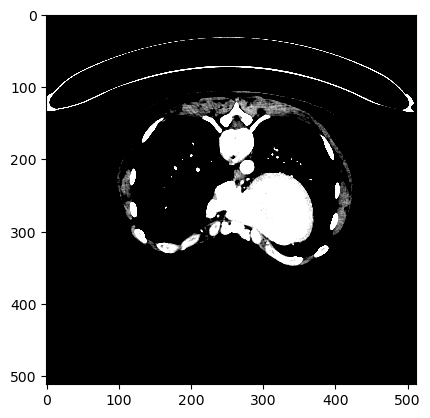

In [3]:
in_dir = "data_exam/"
scan = dicom.read_file(in_dir + '1-001.dcm')
img = scan.pixel_array
plt.imshow(img, cmap="gray", vmin=0, vmax=100)
plt.show()

In [5]:
def load_mask(mask_path):
    roi = io.imread(mask_path)
    mask = roi > 0
    return mask

def get_values(img, mask_path):
    mask = load_mask(mask_path)
    return img[mask]

def get_gaussian_distributions(values, min_hu = -200, max_hu = 1000):
    hu_range = np.arange(min_hu, max_hu, 1.0)
    mu = np.mean(values)
    std = np.std(values)
    pdf = norm.pdf(hu_range, mu, std)
    return pdf


paths = ['BloodROI.png', 'MyocardiumROI.png']
values = [get_values(img, in_dir + path) for path in paths]

209.98726921194577 295.58624588055665


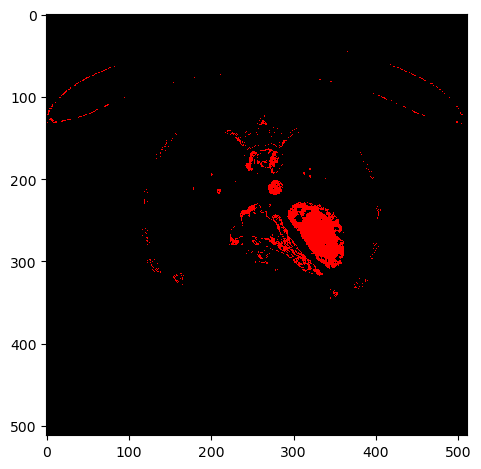

In [14]:
mu = [np.mean(i) for i in values]
std = [np.std(i) for i in values]

min_thres_blood = mu[0]-3*std[0]
max_thres_blood = mu[0]+3*std[0]
min_thres_myocardium = mu[1]-3*std[1]
max_thres_myocardium = mu[1]+3*std[1]
print(min_thres_blood, max_thres_blood)

bin_img = (img > min_thres_blood) & (img < max_thres_blood)
label_colour = color.label2rgb(bin_img)
io.imshow(label_colour)

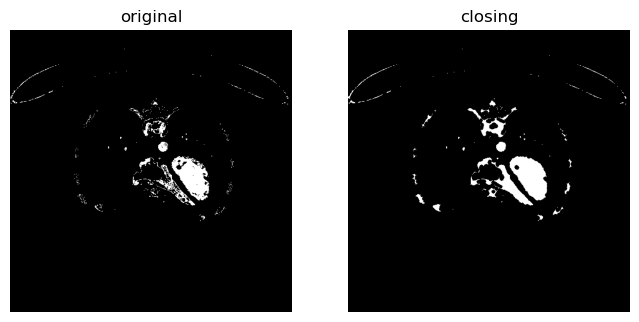

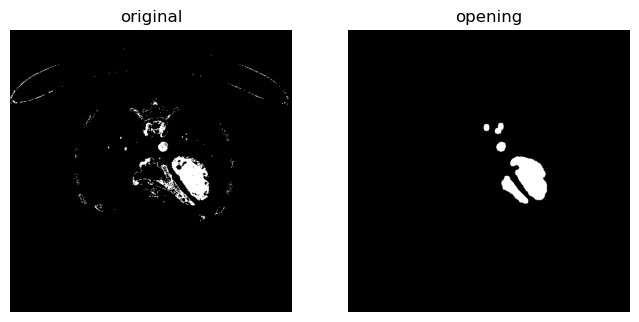

In [10]:
footprint = disk(3)
closed = closing(bin_img, footprint)
plot_comparison(bin_img, closed, 'closing')

footprint = disk(5)
opened = opening(closed, footprint)
plot_comparison(bin_img, opened, 'opening')

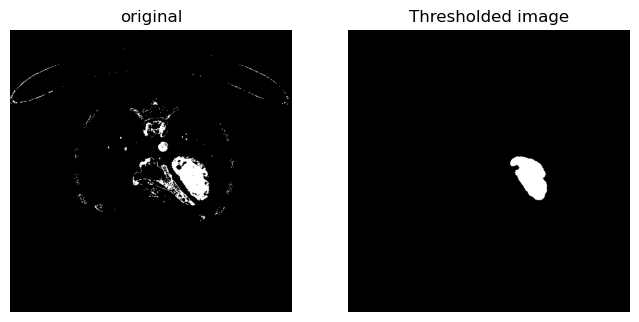

In [12]:
min_area = 2500
max_area = 5000

label_img = measure.label(opened)
region_props = measure.regionprops(label_img)
# Create a copy of the label_img
label_img_filter = label_img
for region in region_props:
    # Find the areas that do not fit our criteria
    if region.area > max_area or region.area < min_area:
        # set the pixels in the invalid areas to background
        for cords in region.coords:
            label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
plot_comparison(bin_img, i_area, 'Thresholded image')

In [15]:
len(region_props)

5

In [13]:
def DICE_score(i_area, ground_truth_img):
    i_area = i_area
    gt_bin = ground_truth_img > 0
    dice_score = 1 - distance.dice(i_area.ravel(), gt_bin.ravel())
    return dice_score

ground_truth_img = io.imread(in_dir + 'BloodGT.png')
dice_score = DICE_score(i_area, ground_truth_img)
dice_score

0.9375729288214703

In [18]:
min_hu = np.min(img)
max_hu = np.max(img)

class_sorted = []
mean_classes = [np.mean(i) for i in values]
for i in range(len(paths)):
      class_sorted.append((paths[i], mean_classes[i]))
class_sorted.sort(key=lambda x: x[1])

midway_points = [(class_sorted[i][1] + class_sorted[i+1][1]) / 2 for i in range(len(class_sorted) - 1)]
print('Class: ',[i[0] for i in class_sorted])
print('Midway point:',midway_points)

print('')
ranges = [min_hu] + midway_points + [max_hu]
for i in range(len(midway_points)+1):
    print(class_sorted[i][0][:-7], 'is in the range [', ranges[i], ',', ranges[i+1], ']')
    
t_1 = midway_points[0]
print('\nt_1 = ', t_1)

Class:  ['MyocardiumROI.png', 'BloodROI.png']
Midway point: [178.41210536488592]

Myocardium is in the range [ -1024 , 178.41210536488592 ]
Blood is in the range [ 178.41210536488592 , 1125 ]

t_1 =  178.41210536488592


## Landmark based registration

In [25]:
src = np.array([[1,0],[5,0], [2,4], [4,4], [3,6]]) 
dst = np.array([[3,1], [7,1], [3.5,3], [5.5,5], [4.5, 6]])


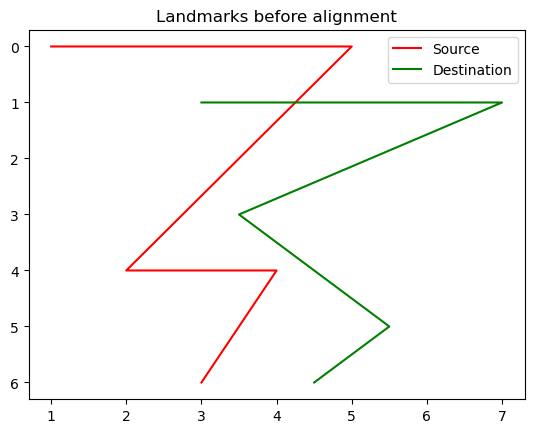

In [26]:
fig, ax = plt.subplots()
ax.plot(src[:, 0], src[:, 1], '-r', markersize=12, label="Source")
ax.plot(dst[:, 0], dst[:, 1], '-g', markersize=12, label="Destination")
ax.invert_yaxis()
ax.legend()
ax.set_title("Landmarks before alignment")
plt.show()

In [27]:
e_x = src[:, 0] - dst[:, 0]
error_x = np.linalg.norm(e_x)**2
e_y = src[:, 1] - dst[:, 1]
error_y = np.linalg.norm(e_y)**2
f_before = error_x + error_y
print(f"Landmark alignment error F_before: {f_before}")


Landmark alignment error F_before: 18.75


In [31]:
a = np.zeros((5, 2))
for i in range(len(src)):
    a[i] = src[i]/5

In [33]:
a.sum(axis=0)

array([3. , 2.8])

In [34]:
b = np.zeros((5, 2))
for i in range(len(dst)):
    b[i] = dst[i]/5
    
b.sum(axis=0)

array([4.7, 3.2])

In [42]:
al = b.sum(axis=0)-a.sum(axis=0)
al

array([1.7, 0.4])

In [41]:
src[0]+al

array([2.7, 0.4])

In [43]:
tform = SimilarityTransform()
tform.estimate(src, dst)
src_transform = matrix_transform(src, tform.params)
src_transform

array([[3.33505155, 0.55670103],
       [6.75773196, 1.05154639],
       [3.69587629, 4.10309278],
       [5.40721649, 4.35051546],
       [4.30412371, 5.93814433]])

In [45]:
np.rad2deg(tform.rotation)

8.226722464108176

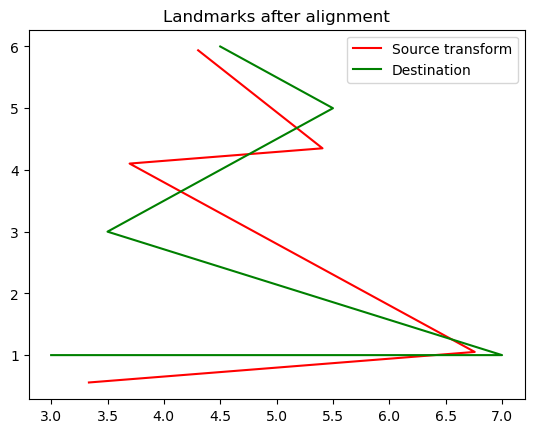

In [24]:
fig, ax = plt.subplots()
ax.plot(src_transform[:, 0], src_transform[:, 1], '-r', markersize=12, label="Source transform")
ax.plot(dst[:, 0], dst[:, 1], '-g', markersize=12, label="Destination")
#ax.invert_yaxis()
ax.legend()
ax.set_title("Landmarks after alignment")
plt.show()

## Pixelwise operations

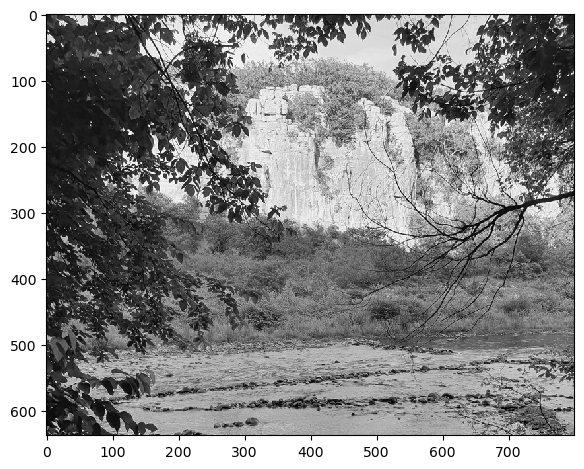

In [46]:
in_dir = 'data_exam/'
im_org = io.imread(f'{in_dir}ardeche_river.jpg')
im_org = color.rgb2gray(im_org)
io.imshow(im_org)

In [57]:
def histogram_stretch(img_in):
    """
    Stretches the histogram of an image 
    :param img_in: Input image
    :return: Image, where the histogram is stretched so the min values is 0 and the maximum value 255
    """
    # img_as_float will divide all pixel values with 255.0
    img_float = img_as_float(img_in)
    min_val = img_float.min()
    max_val = img_float.max()
    min_desired = 0.2
    max_desired = 0.8
    
    for i in range(0, img_float.shape[0]):
        for j in range(0,img_float.shape[1]):
            val = img_float[i][j]
            img_float[i][j] = (max_desired - min_desired) / (max_val-min_val) * (val - min_val) + min_desired
    
    # img_as_ubyte will multiply all pixel values with 255.0 before converting to unsigned byte
    return img_float

In [58]:
histogram_stretched = histogram_stretch(im_org)
histogram_stretched.mean()

0.4763035761289877

In [64]:
prewitt_filter = prewitt_h(histogram_stretched)
prewitt_filter.max()

0.5177194509803922

255509

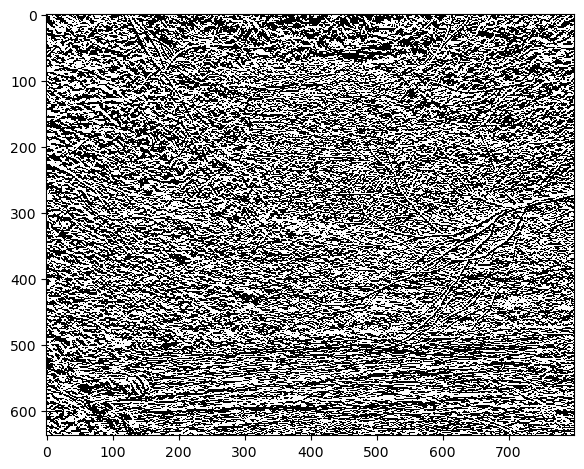

In [69]:
bin_img = prewitt_filter < np.mean(prewitt_filter)
io.imshow(bin_img)
bin_img.sum()

## Principal component analysis

In [106]:
data = np.loadtxt('data_exam' + '/pistachio_data.txt', comments="%")
df = pd.DataFrame(data, columns=['AREA', 'PERIMETER', 'MAJOR_AXIS', 'MINOR_AXIS', 'ECCENTRICITY', 'EQDIASQ', 'SOLIDITY', 'CONVEX_AREA', 'EXTENT', 'ASPECT_RATIO', 'ROUNDNESS', 'COMPACTNESS'])

In [107]:
# Subtract the mean
df = df - df.mean()

In [108]:
for col in df.columns:
    std = df[col].std()
    print(f"Standard deviation for {col}: {std}")
    for row in df.index:
        df[col][row] = df[col][row]/std

Standard deviation for AREA: 12617.070318775259
Standard deviation for PERIMETER: 312.1658952011594
Standard deviation for MAJOR_AXIS: 38.98847481118697
Standard deviation for MINOR_AXIS: 24.056043629475106
Standard deviation for ECCENTRICITY: 0.03173255665336145
Standard deviation for EQDIASQ: 27.51749864965434
Standard deviation for SOLIDITY: 0.047496844833056835
Standard deviation for CONVEX_AREA: 12354.185693405117
Standard deviation for EXTENT: 0.05261592316592967
Standard deviation for ASPECT_RATIO: 0.2118664224566339
Standard deviation for ROUNDNESS: 0.1845105640259818
Standard deviation for COMPACTNESS: 0.0327792580420751


In [109]:
pca = PCA()
pca.fit(df)
X = pca.transform(df)

In [110]:
pca.explained_variance_ratio_[:4].sum()

0.9711907557483043

In [111]:
# Back to numpy after preprocessing
data = df.values

# Find covariance matrix
c_x_np = np.cov(data.T)

np.abs(c_x_np).max()

1.0000000000000004

In [112]:
# Calculate eigenvalues and eigenvectors (PC components)
values, vectors = np.linalg.eig(c_x_np)

# Project data onto PC space
pc_proj = vectors.T.dot(data[0])

In [113]:
pc_proj

array([ 7.15143094e-01,  4.20458072e+00,  8.79740041e-01,  6.29414603e-01,
        7.34909587e-02, -2.82915365e-01,  8.02536416e-02,  2.04824870e-01,
       -4.93838323e-02, -2.08559945e-02, -2.46783440e-02,  1.97223739e-03])

In [114]:
nut1 = pca.transform(data[0].reshape(1, -1))
#data[0]


c:\Users\Naja-\anaconda3\envs\image\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [121]:
np.sum(( mean_point- nut1) ** 2)

19.497356525982465

In [119]:
mean_point = np.mean(X, axis=0)
print(mean_point)

[ 1.77635684e-17 -5.68989300e-17 -5.44009282e-17  3.48332474e-17
  3.63598041e-17  2.89351876e-17 -4.38538095e-17 -2.51187959e-17
  4.04537515e-17 -1.96370697e-17 -3.57353036e-17 -8.53483950e-18]


## Video image analysis frame rate

In [124]:
image_bytes= 2400 * 1200 * 3
bytes_to_mb = 1e-6
mb_to_bytes = 1e6

# Algo time
time_to_process = 0.130 # seconds
algo_frame_rate = 1/time_to_process

# Camera time
transfer_speed = 35 # mb/s
camera_frame_rate = transfer_speed*mb_to_bytes/(image_bytes)

print("\nImages processed by the algo per second: ", algo_frame_rate, '(hz)')
print("Images send by the camera per second is : ", camera_frame_rate, '(hz)')

# Algo
print("\nMB processed by the algo per second: ", algo_frame_rate * image_bytes * bytes_to_mb) 

# Camara
print("MB send by camera per second: ", transfer_speed)



Images processed by the algo per second:  7.692307692307692 (hz)
Images send by the camera per second is :  4.050925925925926 (hz)

MB processed by the algo per second:  66.46153846153845
MB send by camera per second:  35


## Change detection and color space conversions

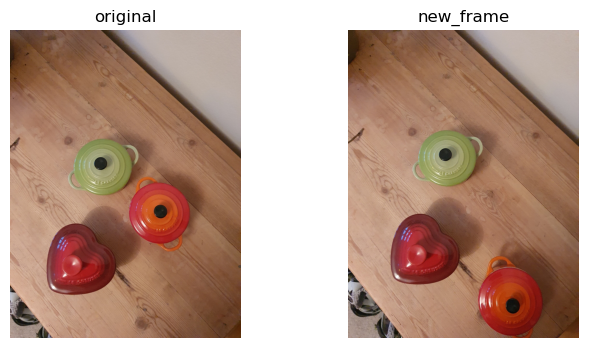

In [139]:
in_dir = "data_exam/"
im_name = "frame_1.jpg"
im_background = io.imread(in_dir + im_name)
im_name = "frame_2.jpg"
im_new_frame = io.imread(in_dir + im_name)
plot_comparison(im_background, im_new_frame, "new_frame")

In [140]:
im_background = color.rgb2hsv(im_background)
im_new_frame = color.rgb2hsv(im_new_frame)

# Get the hue component
s_img_background = im_background[:, :, 1]
s_img_new = im_new_frame[:, :, 1]

s_img_background = s_img_background*255
s_img_new = s_img_new*255

In [141]:
blend = np.abs(s_img_background - s_img_new)

In [142]:
mu = blend.mean()
std = blend.std()

thres = mu + 2*std

changed_pixels= blend > thres
print(thres)

print("Number of changed pixels:", changed_pixels.sum())
print("Percentage of changed pixels:", changed_pixels.sum()/im_background.size)

83.16702036658369
Number of changed pixels: 24820
Percentage of changed pixels: 0.026931423611111113


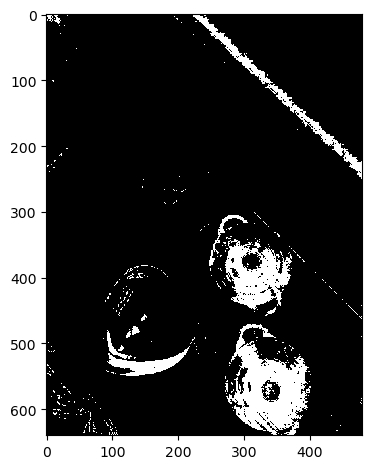

In [151]:
io.imshow(changed_pixels)

c:\Users\Naja-\anaconda3\envs\image\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


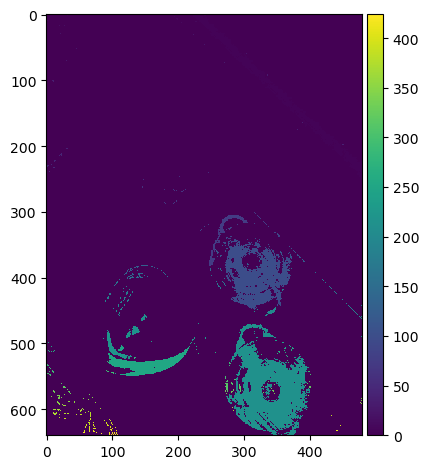

In [152]:
label_img = measure.label(changed_pixels)
region_props = measure.regionprops(label_img)

areas = np.array([prop.area for prop in region_props])
io.imshow(label_img)

In [153]:
areas.max()

10290

In [147]:
region_props[268]

## Aquarium design

In [190]:
image_names =  []
for image in os.listdir('data_exam/fish/'):
    image_names.append(image)

In [191]:
image_names

['discus.jpg',
 'guppy.jpg',
 'kribensis.jpg',
 'neon.jpg',
 'oscar.jpg',
 'platy.jpg',
 'rummy.jpg',
 'scalare.jpg',
 'tiger.jpg',
 'zebra.jpg']

In [192]:
training_images = []
in_dir = 'data_exam/fish/'
for i in image_names:
    file = io.imread(f'{in_dir}/'+ f'{i}')
    height, width, channels = file.shape    
    training_images.append((file).flatten())

    
print("height:", height, "  width:", width, "  channels:", channels)

height: 400   width: 400   channels: 3


In [157]:
mean_img = np.mean(training_images, axis=0)

In [197]:
pca = PCA(n_components=6)
pca.fit(training_images)
components = pca.components_
components.shape
pca.explained_variance_ratio_[:2].sum()

0.4592135208505368

In [198]:
X = pca.transform(training_images)

In [204]:
dist = np.zeros(10)
for i in range(10):
    dist[i] = distance.euclidean(X[i], X[3])
    
print(dist)
print("The closest :", image_names[np.argmax(dist)])

[55723.95878612 62158.22501909 41826.73738269     0.
 50044.37256613 69853.88568401 65138.72220817 60584.17393653
 67876.58407372 48915.7716504 ]
The closest : platy.jpg


In [172]:
guppy = training_images[1]
neon = training_images[3]

In [205]:
ssd = np.sum((guppy- neon) ** 2)
ssd

49587814

In [175]:
sub_data = training_images - neon
sub_distances = np.linalg.norm(sub_data, axis=1)
biggest_idx = sub_distances.argmax()
smallest_idx = sub_distances.argmin()
print("Futhest away ", image_names[biggest_idx])
print("Closest to :", image_names[smallest_idx])

Futhest away  rummy.jpg
Closest to : neon.jpg


## 3D medical image registration

In [4]:
def rotation_matrix(pitch, roll, yaw, deg = False):
    """
    Return the rotation matrix associated with the Euler angles roll, pitch, yaw.
    
    Parameters
    ----------
    pitch : float
        The rotation angle around the x-axis.
    roll : float
        The rotation angle around the y-axis.
    yaw : float
        The rotation angle around the z-axis.
    deg : bool, optional
        If True, the angles are given in degrees. If False, the angles are given
        in radians. Default: False.
    """
    if deg:
        roll = np.deg2rad(roll)
        pitch = np.deg2rad(pitch)
        yaw = np.deg2rad(yaw)

    R_x = np.array([[1, 0,             0,             0],
                    [0, np.cos(pitch),  -np.sin(pitch),  0],
                    [0, np.sin(pitch), np.cos(pitch),  0],
                    [0, 0,             0,             1]])

    R_y = np.array([[np.cos(roll), 0, np.sin(roll), 0],
                    [0, 1, 0, 0],
                    [-np.sin(roll), 0, np.cos(roll), 0],
                    [0, 0, 0, 1]])

    R_z = np.array([[np.cos(yaw),  -np.sin(yaw), 0, 0],
                    [np.sin(yaw), np.cos(yaw),  0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]])

    R = np.dot(np.dot(R_x, R_y), R_z)

    return R

In [5]:
dir_in = 'data_exam/'
v1_vol_sitk = sitk.ReadImage(dir_in + 'ImgT1_v1.nii')
v2_vol_sitk = sitk.ReadImage(dir_in + 'ImgT1_v2.nii')

# Display the volume
#imshow_orthogonal_view(v1_vol_sitk, title='T1_v1.nii')
#imshow_orthogonal_view(v2_vol_sitk, title='T1_v2.nii')

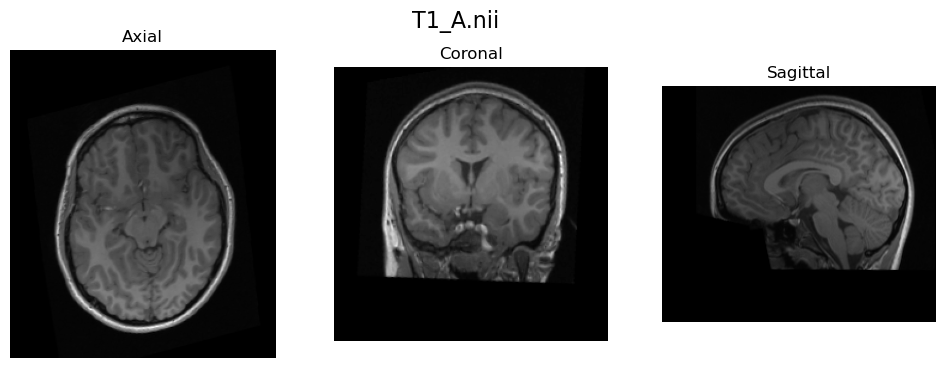

In [6]:
array_v1 = sitk.GetArrayFromImage(v1_vol_sitk)
array_v2 = sitk.GetArrayFromImage(v2_vol_sitk)
translation = (0,-15,0)
transform = sitk.AffineTransform(3)
A = np.array([[0.98,-0.16, 0.17, 0],
              [0.26,0.97,0, -15],
              [-0.17, 0.04, 0.98, 0],
              [0,0,0,1]])


centre_image = np.array(v2_vol_sitk.GetSize()) / 2 - 0.5 # Image Coordinate System
centre_world = v2_vol_sitk.TransformContinuousIndexToPhysicalPoint(centre_image) # World Coordinate System
aff_matrix = A[:3, :3]

transform.SetCenter(centre_world) # Set the rotation centre
transform.SetMatrix(aff_matrix.flatten()) # Set the rotation matrix
transform.SetTranslation(translation) # Set the translation

ImgT1_A = sitk.Resample(v2_vol_sitk, transform)

imshow_orthogonal_view(ImgT1_A, origin=None,title='T1_A.nii')

In [9]:
fixed_image = sitk.ReadImage(dir_in + 'ImgT1_v1.nii')
moving_image = sitk.ReadImage(dir_in + 'ImgT1_v2.nii')

# Set the registration - Fig. 1 from the Theory Note
R = sitk.ImageRegistrationMethod()

initTransform = sitk.Euler3DTransform()
R.SetInitialTransform(initTransform, inPlace=False)

tform_reg = R.Execute(fixed_image, moving_image)

# Get the parameters
params = tform_reg.GetParameters()

# Convert rotations from radians to degrees
rotations = [np.degrees(param) for param in params[:3]]
translations = params[3:]

RuntimeError: Exception thrown in SimpleITK ImageRegistrationMethod_Execute: D:\a\1\sitk\Code\Registration\src\sitkImageRegistrationMethod_CreateOptimizer.cxx:405:
sitk::ERROR: LogicError: Unexpected case!

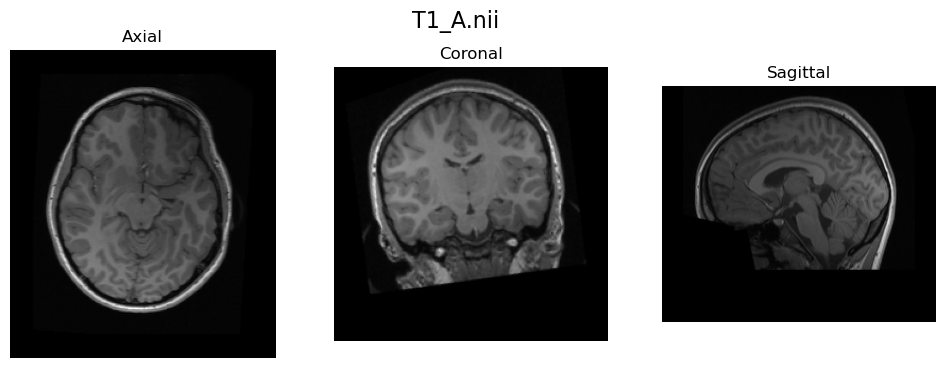

In [289]:
fixed_image = sitk.ReadImage(dir_in + 'ImgT1_v1.nii')
moving_image = sitk.ReadImage(dir_in + 'ImgT1_v2.nii')

# Define the roll rotation in radians
angle = -20  # degrees
roll_radians = np.deg2rad(angle)

# Create the Affine transform and set the rotation
transform = sitk.AffineTransform(3)

centre_image = np.array(moving_image.GetSize()) / 2 - 0.5 # Image Coordinate System
centre_world = moving_image.TransformContinuousIndexToPhysicalPoint(centre_image) # World Coordinate System
rot_matrix = rotation_matrix(0, roll_radians, 0)[:3, :3] # SimpleITK inputs the rotation and the translation separately

transform.SetCenter(centre_world) # Set the rotation centre
transform.SetMatrix(rot_matrix.T.flatten())

# Apply the transformation to the image
ImgT1_A = sitk.Resample(moving_image, transform)

imshow_orthogonal_view(ImgT1_A, origin=None,title='T1_A.nii')


In [10]:
# Create a mask where only voxel intensities > 50 are True
mask = sitk.BinaryThreshold(fixed_image, lowerThreshold=51, upperThreshold=255)

# Apply the mask to the image
masked_image = sitk.Mask(fixed_image, mask)


In [14]:
np.mean((masked_image - ImgT1_A ) ** 2)

18942.780112151224

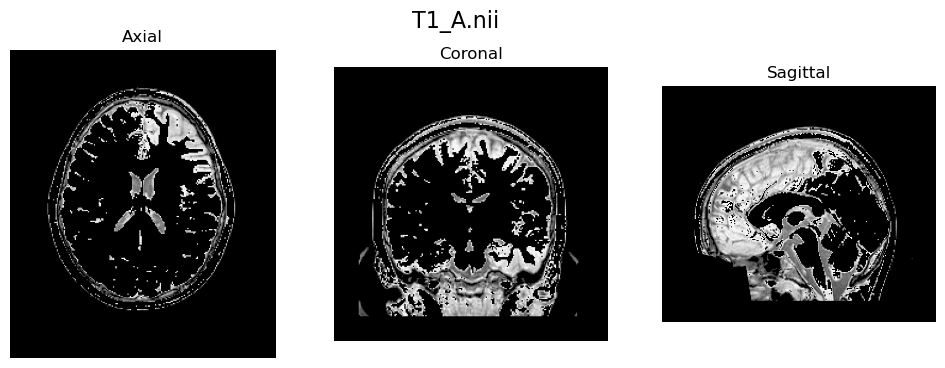

In [11]:
imshow_orthogonal_view(masked_image, origin=None,title='T1_A.nii')

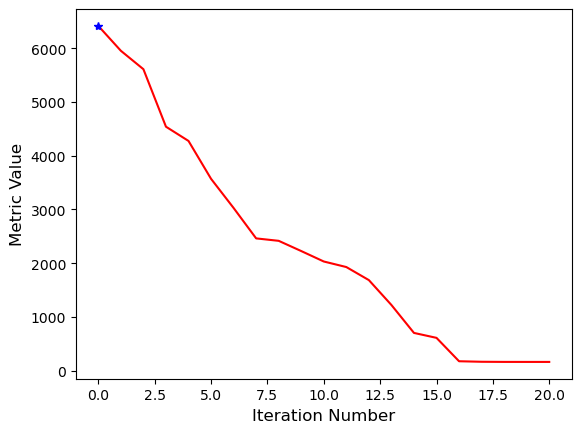

In [16]:
from IPython.display import clear_output
fixed_image = sitk.ReadImage(dir_in + 'ImgT1_v1.nii')
moving_image = sitk.ReadImage(dir_in + 'ImgT1_v2.nii')

# Set the registration - Fig. 1 from the Theory Note
R = sitk.ImageRegistrationMethod()

# Set a one-level the pyramid scheule. [Pyramid step]
R.SetShrinkFactorsPerLevel(shrinkFactors = [2])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the interpolator [Interpolation step]
R.SetInterpolator(sitk.sitkLinear)

# Set the similarity metric [Metric step]
R.SetMetricAsMeanSquares()

# Set the sampling strategy [Sampling step]
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.50)

# Set the optimizer [Optimization step]
R.SetOptimizerAsPowell(stepLength=0.1, numberOfIterations=25)

# Initialize the transformation type to rigid 
initTransform = sitk.Euler3DTransform()
R.SetInitialTransform(initTransform, inPlace=False)

# Some extra functions to keep track to the optimization process 
# R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R)) # Print the iteration number and metric value
R.AddCommand(sitk.sitkStartEvent, start_plot) # Plot the similarity metric values across iterations
R.AddCommand(sitk.sitkEndEvent, end_plot)
R.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
R.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(R))

# Estimate the registration transformation [metric, optimizer, transform]
tform_reg = R.Execute(fixed_image, moving_image)

# Apply the estimated transformation to the moving image
ImgT1_B = sitk.Resample(moving_image, tform_reg)



In [17]:
estimated_tform = tform_reg.GetNthTransform(0).GetMatrix() # Transform matrix
estimated_translation = tform_reg.GetNthTransform(0).GetTranslation() # Translation vector
params = tform_reg.GetParameters() # Parameters (Rx, Ry, Rz, Tx, Ty, Tz)

## Hough

In [ ]:
src = np.array([[1,0],[5,0], [2,4], [4,4], [3,6]]) 

In [269]:
list = [ (-45,4.9), (-45, -0.7), (0, 3), (-45, 0.7), (45, 3.5)]
points = [(1,0),(5,0), (2,4), (4,4), (3,6)]

for p in points:
    for l in list:
        if (l[1] == p[0]*np.cos(math.radians(l[0])) + p[1]*np.sin(math.radians(l[0]))):
            print('Point:',p,'rho, theta', l)
   
   


Point: (3, 6) rho, theta (0, 3)
